<a href="https://colab.research.google.com/github/phantomer-ai/AIFFEL_quest_cr/blob/main/%ED%8F%90%EB%A0%B4%EC%A7%84%EB%8B%A8_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8%EC%9D%98_%EC%82%AC%EB%B3%B8%EC%9D%B4%EC%A7%80%EB%A7%8C_%EC%84%B1%EA%B3%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# Colab에 Kaggle API 설정
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()  # kaggle.json 파일 업로드

# 권한 설정
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Kaggle API 설치
!pip install kaggle


Saving kaggle.json to kaggle.json


In [ ]:
# Kaggle 데이터셋 다운로드
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# 압축 해제

!unzip -o chest-xray-pneumonia.zip -d /content/



In [5]:

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수 (Colab 환경에 맞게 수정)
ROOT_PATH = "/content/chest_xray"  # 압축 해제된 데이터 경로
TRAIN_PATH = os.path.join(ROOT_PATH, "train", "*", "*")
VAL_PATH = os.path.join(ROOT_PATH, "val", "*", "*")
TEST_PATH = os.path.join(ROOT_PATH, "test", "*", "*")

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(f"ROOT_PATH: {ROOT_PATH}")
print(f"TRAIN_PATH: {TRAIN_PATH}")
print(f"VAL_PATH: {VAL_PATH}")
print(f"TEST_PATH: {TEST_PATH}")


ROOT_PATH: /content/chest_xray
TRAIN_PATH: /content/chest_xray/train/*/*
VAL_PATH: /content/chest_xray/val/*/*
TEST_PATH: /content/chest_xray/test/*/*


In [6]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [7]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [8]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/content/chest_xray/train/NORMAL/IM-0703-0001.jpeg
Pneumonia image path
/content/chest_xray/train/PNEUMONIA/person1425_virus_2438.jpeg


In [9]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [10]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [11]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047




# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

🚨 문제 분석
# 이 에러는 모델에 전달되는 데이터 중 bool 타입이 포함되어 있어서 발생하는 문제입니다.
텐서플로우 모델 (tf.keras.Model)은 float32 또는 int32 타입의 데이터를 필요로 합니다.
하지만 현재 bool 타입의 데이터(라벨)가 들어가서 에러가 발생한 것입니다.

✅ 해결 방법
1. get_label()에서 라벨을 bool에서 float32로 변환
현재 get_label() 함수에서 라벨을 반환할 때 bool 값(True or False)을 반환하고 있을 가능성이 큽니다.

In [25]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return tf.cast(parts[-2] == "PNEUMONIA", tf.float32)  # True → 1.0, False → 0.0


In [28]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = tf.cast(get_label(file_path), tf.float32) # 라벨 검출
# label = get_label(file_path)  # 여전히 bool 타입일 가능성이 있음 gpt가 고치라고함
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [29]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [30]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0.0


In [31]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [32]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

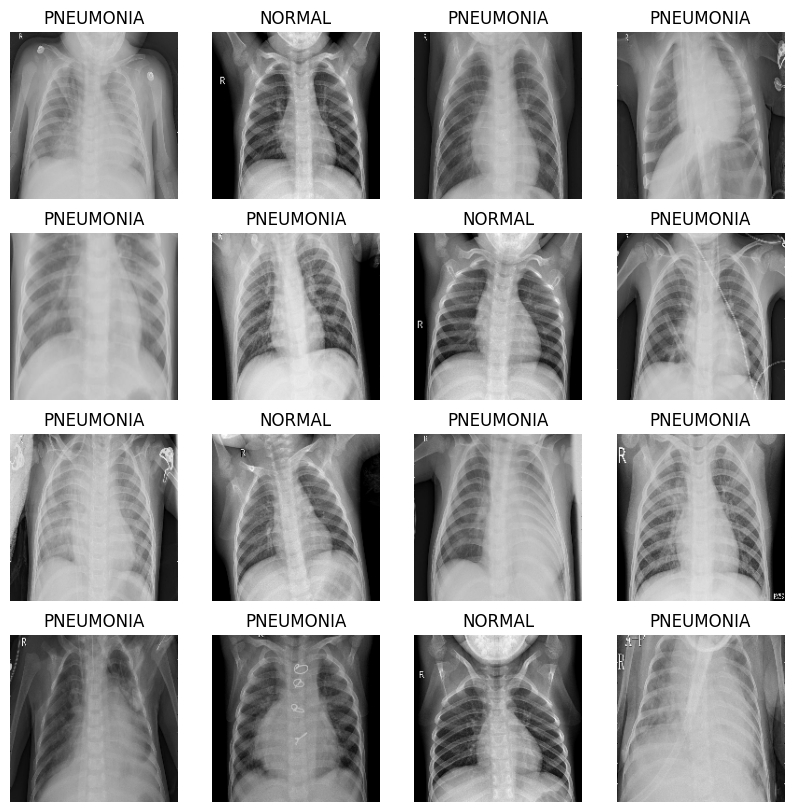

In [33]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

4. CNN 모델링
이미지 처리에 특화된 딥러닝 모델인 CNN을 통해 모델링을 하고 결과를 만들어 보겠습니다.

CNN, Convolutional Neural Network 요약
먼저, Convolution block을 만듭니다. conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결합니다. 그리고 Max Pooling을 합니다.

In [34]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

In [35]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [36]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [37]:
#5. 데이터 imbalance 처리

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [38]:
#6. 모델훈련
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [39]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.7374 - loss: 0.5290 - precision: 0.9272 - recall: 0.7050 - val_accuracy: 0.7356 - val_loss: 0.7602 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.9083 - loss: 0.2369 - precision: 0.9712 - recall: 0.9033 - val_accuracy: 0.7327 - val_loss: 1.3109 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.9331 - loss: 0.1876 - precision: 0.9774 - recall: 0.9317 - val_accuracy: 0.7337 - val_loss: 0.8218 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - accuracy: 0.9396 - loss: 0.1706 - precision: 0.9793 - recall: 0.9388 - val_accuracy: 0.9625 - val_loss: 0.0984 - val_precision: 0.9524 - val_recall: 0.9987
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 341s 1s/step - accuracy: 0.9394 - loss: 0.1631 - precision: 0.9835 - recall: 0.9352 - val_accuracy: 0.9683 - val_los

In [ ]:
#7. 결과확인

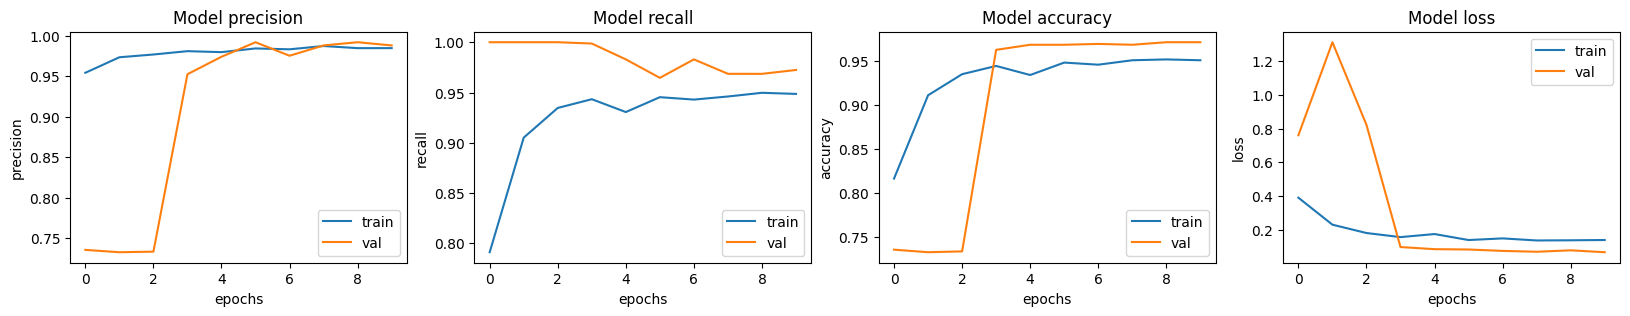

In [40]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [41]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 400ms/step - accuracy: 0.7828 - loss: 0.7298 - precision: 0.7447 - recall: 0.9934
Loss: 0.728704571723938,
Accuracy: 0.7804487347602844,
Precision: 0.7428023219108582,
Recall: 0.9923076629638672
